Exploring the $\chi^2$ distribution
===

Start with some model to generate random data.  <br> 
We'll use $0.2+\frac{sin(x)}{x+1}$ over the range $0\leq x<15$ <br>
Generate $N$ random numbers according to this distribution and make a histogram of the results using 30 bins. 

An easy way to generate random numbers according to an arbitrary distribution is to use rejection sampling (here's a great [decription  of the technique](https://matthewfeickert.github.io/Statistics-Notes/notebooks/simulation/Rejection-Sampling-MC.html) )

1) Make a histogram of your random distribution.  Verify that the the numbers you generated agree with the shape of the function.  Generate at least 10000 points and plot your data in a histogram with errorbars.  You can use numpy+matplotlib+etc, PyROOT, or a mix.  Think about how to appropriately normalize your function, then overlay it with the data.  The normalization depends on the number of bins, the bin range and the number of points thrown.  You may find it easier to first nromalize the area of your function to 1.0, thus turning it into a proper PDF.  

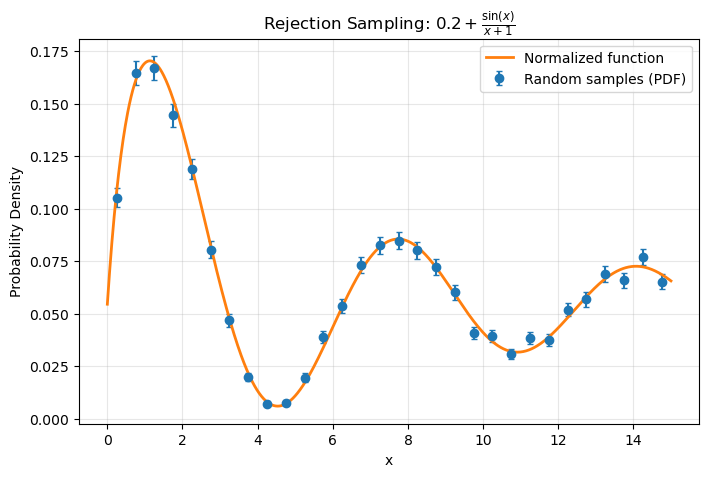

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the function
def f(x):
    return 0.2 + np.sin(x) / (x + 1)

# Step 2: Rejection sampling
def generate_samples(N=10000, xmin=0, xmax=15):
    x_vals = []
    
    xs = np.linspace(xmin, xmax, 10000)
    fmax = np.max(f(xs))
    
    while len(x_vals) < N:
        xr = np.random.uniform(xmin, xmax)
        yr = np.random.uniform(0, fmax)
        if yr < f(xr):
            x_vals.append(xr)
    
    return np.array(x_vals)

samples = generate_samples(10000)

# Step 3: Histogram with error bars
bins = 30
counts, bin_edges = np.histogram(samples, bins=bins, range=(0, 15))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
errors = np.sqrt(counts)

# Normalize histogram to PDF form
bin_width = bin_edges[1] - bin_edges[0]
hist_pdf = counts / (np.sum(counts) * bin_width)

# Step 4: Normalize function to unit area (PDF)
xs = np.linspace(0, 15, 1000)
fs = f(xs)
fs_norm = fs / np.trapezoid(fs, xs)

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(bin_centers, hist_pdf, yerr=errors/(np.sum(counts)*bin_width),
             fmt='o', label='Random samples (PDF)', capsize=2)
plt.plot(xs, fs_norm, label='Normalized function', linewidth=2)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Rejection Sampling: $0.2 + \\frac{\\sin(x)}{x+1}$')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

2) Repeat the above experiment at least 1000 times.  For each experiment calculate the $\chi^2$ of your data with respect to your (properly normalized) model.  Plot (histogram) the $\chi^2$ distribution and compare it to the functional form of the $\chi^2(ndof=30)$ distribution.  You can find the form of the $\chi^2(ndof)$ PDF function in many places and implement it using the Gamma function or use a premade function, eg:
* [wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution)
* [scipy.stats.chi2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2)

Running experiments: 100%|██████████| 1000/1000 [00:04<00:00, 241.32it/s]


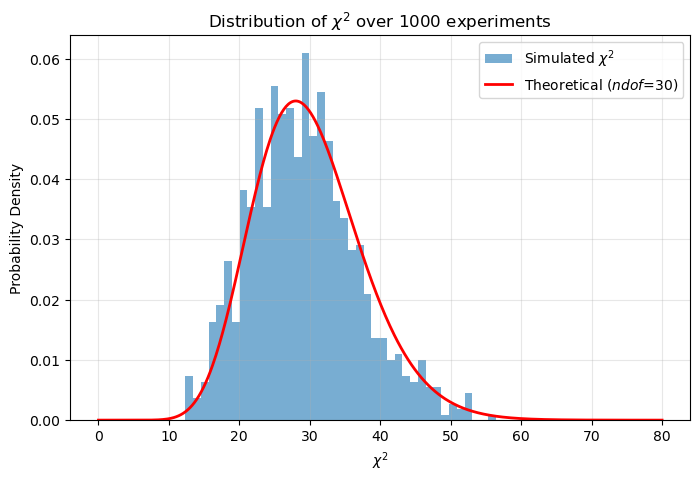

Mean χ² = 29.10 (Expected ≈ 30)
Std of χ² = 7.64 (Expected ≈ 7.75)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from tqdm import tqdm 

# Define the probability function
def f(x):
    return 0.2 + np.sin(x) / (x + 1)

# Fast rejection sampling using vectorization
def generate_samples(N=10000, xmin=0, xmax=15):
    xs = np.linspace(xmin, xmax, 10000)
    fmax = np.max(f(xs))
    accepted = []

    while len(accepted) < N:
        xr = np.random.uniform(xmin, xmax, size=2*N)
        yr = np.random.uniform(0, fmax, size=2*N)
        mask = yr < f(xr)
        accepted.extend(xr[mask])
    
    return np.array(accepted[:N])

# Expected counts based on normalized model
def expected_counts(bin_edges, total_points):
    xs = np.linspace(0, 15, 10000)
    fs = f(xs)
    fs_norm = fs / np.trapezoid(fs, xs)

    e_counts = []
    for i in range(len(bin_edges) - 1):
        idx = (xs >= bin_edges[i]) & (xs < bin_edges[i+1])
        prob = np.trapezoid(fs_norm[idx], xs[idx])
        e_counts.append(prob * total_points)
    return np.array(e_counts)

# Run multiple experiments to calculate chi2 distribution
num_experiments = 1000
num_points = 10000
num_bins = 30
chi2_values = []

for _ in tqdm(range(num_experiments), desc="Running experiments"):
    x_data = generate_samples(num_points)
    counts, bin_edges = np.histogram(x_data, bins=num_bins, range=(0, 15))
    expected = expected_counts(bin_edges, num_points)

    mask = expected > 0
    chi2_val = np.sum(((counts[mask] - expected[mask])**2) / expected[mask])
    chi2_values.append(chi2_val)

chi2_values = np.array(chi2_values)

# Plot chi2 distribution vs theoretical chi2
plt.figure(figsize=(8,5))
plt.hist(chi2_values, bins=40, density=True, alpha=0.6, label="Simulated $\chi^2$")
x = np.linspace(0, 80, 500)
plt.plot(x, chi2.pdf(x, df=num_bins), 'r-', lw=2, label=f"Theoretical ($ndof$={num_bins})")
plt.xlabel(r"$\chi^2$")
plt.ylabel("Probability Density")
plt.title(r"Distribution of $\chi^2$ over 1000 experiments")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Mean χ² = {np.mean(chi2_values):.2f} (Expected ≈ {num_bins})")
print(f"Std of χ² = {np.std(chi2_values):.2f} (Expected ≈ {np.sqrt(2*num_bins):.2f})")


**Only required for Phys5630**

3) Modify your code above to perform the following study. <br>
Repeat (2) for nbins = $ndof = 30, 50, 75, 100$ and calculate the reduced $\chi^2$, eg $\chi^2/ndof$ for each experiment.  Plot the mean value of the reduced $\chi^2$ with errorbars versus $ndof$.  Make a table comparing your calculations to the expected results.

Bins = 100: 100%|██████████| 1000/1000 [00:05<00:00, 180.96it/s]


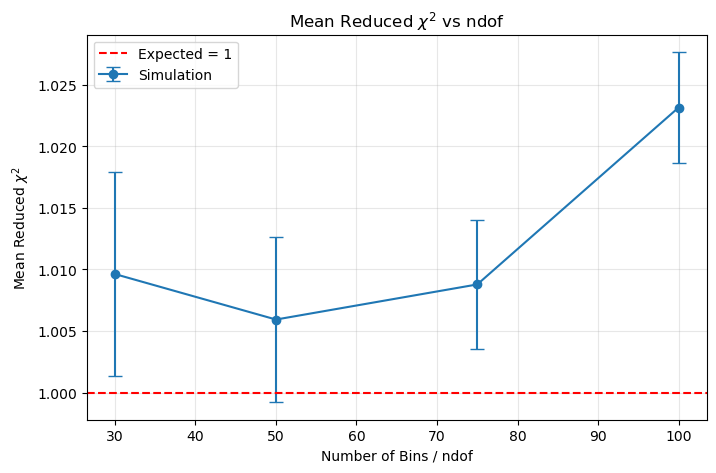

   Bins / ndof  Mean Reduced χ²  Error on Mean  Expected
0           30            1.010          0.008       1.0
1           50            1.006          0.007       1.0
2           75            1.009          0.005       1.0
3          100            1.023          0.004       1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from tqdm import tqdm


def f(x):
    return 0.2 + np.sin(x) / (x + 1)

def generate_samples(N=10000, xmin=0, xmax=15):
    xs = np.linspace(xmin, xmax, 10000)
    fmax = np.max(f(xs))
    accepted = []
    while len(accepted) < N:
        xr = np.random.uniform(xmin, xmax, size=2*N)
        yr = np.random.uniform(0, fmax, size=2*N)
        accepted.extend(xr[yr < f(xr)])
    return np.array(accepted[:N])

def expected_counts(bin_edges, total_points):
    xs = np.linspace(0, 15, 10000)
    fs = f(xs)
    fs_norm = fs / np.trapezoid(fs, xs)
    e_counts = []
    for i in range(len(bin_edges) - 1):
        idx = (xs >= bin_edges[i]) & (xs < bin_edges[i+1])
        prob = np.trapezoid(fs_norm[idx], xs[idx])
        e_counts.append(prob * total_points)
    return np.array(e_counts)

# --- Part 3 ---
num_experiments = 1000
num_points = 10000
bin_list = [30, 50, 75, 100]

mean_reduced = []
err_reduced = []

for bins in bin_list:
    chi2_values = []
    for _ in tqdm(range(num_experiments), desc=f"Bins = {bins}"):
        x_data = generate_samples(num_points)
        counts, bin_edges = np.histogram(x_data, bins=bins, range=(0, 15))
        expected = expected_counts(bin_edges, num_points)
        
        mask = expected > 0
        chi2_val = np.sum(((counts[mask] - expected[mask])**2) / expected[mask])
        reduced = chi2_val / (bins -1)  # ndof = bins - 1 ?check
        chi2_values.append(reduced)

    chi2_values = np.array(chi2_values)
    mean_reduced.append(np.mean(chi2_values))
    err_reduced.append(np.std(chi2_values) / np.sqrt(num_experiments))

# Plot mean reduced χ² vs ndof
plt.figure(figsize=(8,5))
plt.errorbar(bin_list, mean_reduced, yerr=err_reduced, fmt='o-', capsize=5, label="Simulation")
plt.axhline(1, color='r', linestyle='--', label="Expected = 1")
plt.xlabel("Number of Bins / ndof")
plt.ylabel("Mean Reduced $\chi^2$")
plt.title("Mean Reduced $\chi^2$ vs ndof")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print comparison table
import pandas as pd
df = pd.DataFrame({
    "Bins / ndof": bin_list,
    "Mean Reduced χ²": np.round(mean_reduced, 3),
    "Error on Mean": np.round(err_reduced, 3),
    "Expected": [1.0]*len(bin_list)
})
print(df)
